In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split



from paretoset import paretoset
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, CoxPHFitter
from plots import calculate_failure_rate, drop_frames_without_results, min_max_scaling

import argparse
from pathlib import Path
import logging

logger = logging.getLogger(__name__)

In [2]:
FOLDER = Path("output/plots/")
csv_file = FOLDER / "data.csv"
data = pd.read_csv(csv_file, index_col=0)
data.columns = data.columns.str.strip()
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
data.def_value.replace("", 0, inplace=True)
data.atk_value.replace("", 0, inplace=True)
data = drop_frames_without_results(data)
data = calculate_failure_rate(data)
data = min_max_scaling(data)
data.dropna(axis=0, subset=['atk_value', 'atk_param'], inplace=True)
data.dropna(axis=0, subset=['def_value', 'def_param'], inplace=True)
# data=data[data['def_gen'] == 'Gauss-in']
# data=data[data['atk_gen'] == 'HSJ']

print(
    "ResNet152:", data[data['model_layers'] == 152].adv_accuracy.mean(skipna=True), "\n",
    "Resnet101:", data[data['model_layers'] == 101].adv_accuracy.mean(skipna=True), "\n",
    "Resnet50:", data[data['model_layers'] == 50].adv_accuracy.mean(skipna=True), "\n",
    "Resnet34:", data[data['model_layers'] == 34].adv_accuracy.mean(skipna=True), "\n",
    "Resnet18:", data[data['model_layers'] == 18].adv_accuracy.mean(skipna=True), "\n",
)



ResNet152: 0.09777195281782439 
 Resnet101: 0.09993344425956739 
 Resnet50: 0.09634703196347033 
 Resnet34: 0.09648437500000001 
 Resnet18: 0.08609302325581396 



In [3]:
def plot_aft(
    df,
    file,
    event_col,
    duration_col,
    title,
    mtype,
    xlabel=None,
    ylabel=None,
    replacement_dict={},
    **kwargs,
):
    if mtype == "weibull":
        aft = WeibullAFTFitter(**kwargs)
    elif mtype == "log_normal":
        aft = LogNormalAFTFitter(**kwargs)
    elif mtype == "log_logistic":
        aft = LogLogisticAFTFitter(**kwargs)
    elif mtype == "cox":
        aft = CoxPHFitter(**kwargs)
    assert (
        duration_col in df.columns
    ), f"Column {duration_col} not in dataframe with columns {df.columns}"
    if event_col is not None:
        assert (
            event_col in df.columns
        ), f"Column {event_col} not in dataframe with columns {df.columns}"
    aft.fit(df, duration_col=duration_col, event_col=event_col)
    ax = aft.plot()
    labels = ax.get_yticklabels()
    labels = [label.get_text() for label in labels]
    for k, v in replacement_dict.items():
        labels = [label.replace(k, v) for label in labels]
    ax.set_yticklabels(labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.get_figure().tight_layout()
    ax.get_figure().savefig(FOLDER / file)
    logger.info(f"Saved graph to {FOLDER / file}")
    plt.show()
    return ax, aft

def plot_partial_effects(
    file,
    aft,
    covariate_aray,
    values_array,
    title,
    xlabel="Covariate",
    ylabel="Failure rate",
    legend_kwargs={"loc": "upper left"},
    replacement_dict={},
    cmap='coolwarm',
    **kwargs,     
     ):
    plt.gcf().clear()
    # kwargs.pop("replacement_dict")
    pareto = aft.plot_partial_effects_on_outcome(covariate_aray, values_array, cmap=cmap, **kwargs)
    labels = pareto.get_yticklabels()
    labels = [label.get_text() for label in labels]
    for k, v in replacement_dict.items():
        labels = [label.replace(k, v) for label in labels]
    pareto.set_yticklabels(labels)
    pareto.legend(**legend_kwargs)
    pareto.set_ylabel(ylabel)
    pareto.set_xlabel(xlabel)
    pareto.set_title(title)
    pareto.get_figure().tight_layout()
    pareto.get_figure().savefig(FOLDER / file)
    logger.info(f"Saved graph to {FOLDER / file}")
    return pareto

def score_model(aft, train, test):
    train_score = aft.score(train)
    test_score = aft.score(test)
    scores = {'train_score': train_score, 'test_score': test_score}
    plt.show()
    return  scores


def clean_data_for_aft(
    data, kwarg_list, target="adv_failure_rate"
):
    subset = data.copy()
    assert target in subset, f"Target {target} not in dataframe with columns {subset.columns}"
    y = subset[target].copy(deep=True)
    cleaned = pd.DataFrame()
    for kwarg in kwarg_list:
        cleaned = pd.concat([cleaned, subset[kwarg]], axis=1)
    cols = cleaned.columns
    cleaned = pd.DataFrame(subset, columns=cols)
    cleaned.dropna(inplace=True, how='any',)
    cleaned[target] = y
    assert target in cleaned, f"Target {target} not in dataframe with columns {cleaned.columns}"
    return cleaned, y, data

In [4]:

kwarg_list = [
    "accuracy",
    "train_time",
    "predict_time",
    "atk_value",
    "def_value",
    "data.sample.random_state",
    "adv_failure_rate",
    "failure_rate",
    "model_layers",
    "adv_fit_time",
    "model.art.pipeline.initialize.kwargs.optimizer.lr",
    # "def_gen",
    # "atk_gen",
    # "adv_log_loss",
    # "adv_accuracy",
    # "adv_accuracy",
]


# cleaned['accuracy'] = y

In [5]:
target = "failure_rate"
cleaned, y, data = clean_data_for_aft(data, kwarg_list,  target=target)
X_train, X_test, y_train, y_test = train_test_split(cleaned, y,  test_size=0.2, random_state=42)
assert target in cleaned, f"Target {target} not in dataframe with columns {cleaned.columns}"

# from sklearn.preprocessing import PowerTransformer

# pt = PowerTransformer(method='yeo-johnson', standardize=False)
# del X_train[target]
# del X_test[target]
# X_train_cols = X_train.columns
# X_train = pt.fit(X_train).transform(X_train)
# X_test = pt.transform(X_test)
# X_train = pd.DataFrame(X_train, columns=X_train_cols)
# X_test = pd.DataFrame(X_test, columns=X_train_cols)
# X_train[target] = y_train
# y_train = X_train[target]


In [6]:
# sense_dict ={
#     "accuracy" : "max",
#     "train_time" : "min",
#     "predict_time" : "min",
#     # "atk_value" : "diff",
#     # "def_value" : "diff",
#     "data.sample.random_state" : "diff",
#     "adv_failure_rate" : "max",
#     "model_layers" : "diff",
#     "adv_fit_time" : "min",
#     "atk_param" : "diff",
#     "def_param" : "diff",
#     "model.art.pipeline.initialize.kwargs.optimizer.lr" : "diff",
#     "failure_rate" : "maximize",
# }
# subset = X_train.loc[:, sense_dict.keys()]
# senses = sense_dict.values()
# these = paretoset(subset)
# X_train = X_train.iloc[these, :]


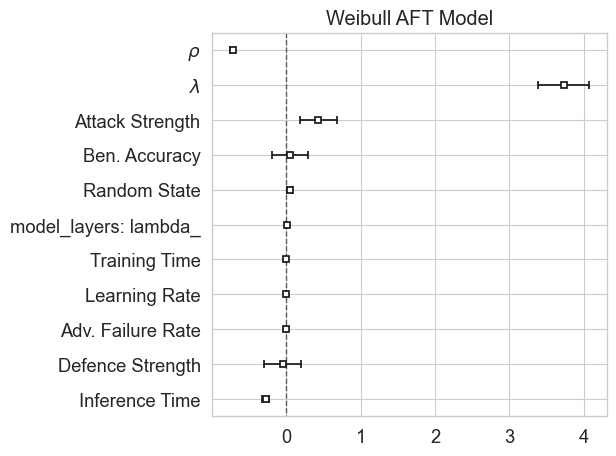

<lifelines.WeibullAFTFitter: fitted with 1917 total observations, 0 right-censored observations>
             duration col = 'adv_fit_time'
                event col = 'failure_rate'
   number of observations = 1917
number of events observed = 1917
           log-likelihood = -5413.65
         time fit was run = 2023-09-22 12:02:53 UTC

---
                                                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                                 
lambda_ accuracy                                            0.05       1.05       0.12            -0.19             0.30                 0.82                 1.34
        adv_failure_rate                                   -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
        atk_value                                           0.43       1.54       0.13             0.18             0.68                 1.20                 1.97
        data.sample.random_state                            0.05       1.05       0.02             0.01             0.08                 1.01                 1.08
        def_value                                          -0.05       0.95       0.13            -0.30             0.20                 0.74                 1.23
        model.art.pipeline.initialize.kwargs.optimizer.lr  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        model_layers                                        0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
        predict_time                                       -0.28       0.76       0.02            -0.32            -0.24                 0.72                 0.79
        train_time                                          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Intercept                                           3.73      41.58       0.17             3.39             4.07                29.58                58.46
rho_    Intercept                                          -0.72       0.49       0.02            -0.76            -0.69                 0.47                 0.50

                                                            cmp to      z      p   -log2(p)
param   covariate                                                                          
lambda_ accuracy                                              0.00   0.41   0.68       0.56
        adv_failure_rate                                      0.00 -57.66 <0.005        inf
        atk_value                                             0.00   3.38 <0.005      10.44
        data.sample.random_state                              0.00   2.73   0.01       7.29
        def_value                                             0.00  -0.37   0.71       0.49
        model.art.pipeline.initialize.kwargs.optimizer.lr     0.00  -0.52   0.60       0.73
        model_layers                                          0.00   2.88 <0.005       7.99
        predict_time                                          0.00 -12.39 <0.005     114.71
        train_time                                            0.00   1.21   0.22       2.15
        Intercept                                             0.00  21.45 <0.005     336.62
rho_    Intercept                                             0.00 -42.18 <0.005        inf
---
Concordance = 0.81
AIC = 10849.31
log-likelihood ratio test = 1602.43 on 9 df
-log2(p) of ll-ratio test = inf

In [7]:
weibull_dict = {
    "Intercept: rho_": "$\\rho$",
    "Intercept: lambda_": "$\lambda$",
    "data.sample.random_state: lambda_": "Random State",
    "def_value: lambda_": "Defence Strength",
    "atk_value: lambda_": "Attack Strength",
    "train_time: lambda_": "Training Time",
    "predict_time: lambda_": "Inference Time",
    "adv_accuracy: lambda_": "Adv. Accuracy",
    "accuracy: lambda_": "Ben. Accuracy",
    "adv_fit_time: lambda_": "Adv. Fit Time",
    "adv_log_loss: lambda_": "Adv. Log Loss",
    "adv_failure_rate: lambda_": "Adv. Failure Rate",
    "failure_rate: lambda_": "Ben. Failure Rate",
    "model_layers: lambda_ ": "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr: lambda_" : "Learning Rate",
    "def_gen" : "Defence",
}

weibull_afr, wft = plot_aft(
    X_train,
    file = "weibull_aft.pdf",
    event_col = target,
    duration_col = "adv_fit_time",
    title = "Weibull AFT Model",
    mtype = "weibull",
    replacement_dict=weibull_dict,
)
wft.print_summary()
wft_scores = score_model(wft, X_train, X_test)


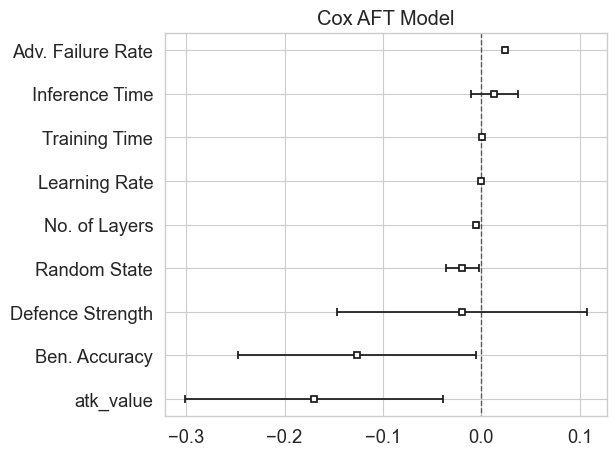

<lifelines.CoxPHFitter: fitted with 1917 total observations, 0 right-censored observations>
             duration col = 'adv_fit_time'
                event col = 'failure_rate'
      baseline estimation = breslow
   number of observations = 1917
number of events observed = 1917
   partial log-likelihood = -9069.47
         time fit was run = 2023-09-22 12:02:55 UTC

---
                                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                 
accuracy                                           -0.13       0.88       0.06            -0.25            -0.00                 0.78                 1.00
train_time                                          0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
predict_time                                        0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
atk_value                                          -0.17       0.84       0.07            -0.30            -0.04                 0.74                 0.96
def_value                                          -0.02       0.98       0.06            -0.15             0.11                 0.86                 1.11
data.sample.random_state                           -0.02       0.98       0.01            -0.04            -0.00                 0.96                 1.00
adv_failure_rate                                    0.02       1.02       0.00             0.02             0.03                 1.02                 1.03
model_layers                                       -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
model.art.pipeline.initialize.kwargs.optimizer.lr  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                                                    cmp to     z      p   -log2(p)
covariate                                                                         
accuracy                                              0.00 -2.04   0.04       4.59
train_time                                            0.00  5.97 <0.005      28.69
predict_time                                          0.00  1.10   0.27       1.89
atk_value                                             0.00 -2.55   0.01       6.53
def_value                                             0.00 -0.30   0.76       0.39
data.sample.random_state                              0.00 -2.27   0.02       5.43
adv_failure_rate                                      0.00 36.55 <0.005     969.18
model_layers                                          0.00 -7.32 <0.005      41.85
model.art.pipeline.initialize.kwargs.optimizer.lr     0.00 -0.55   0.58       0.79
---
Concordance = 0.95
Partial AIC = 18156.95
log-likelihood ratio test = 7015.80 on 9 df
-log2(p) of ll-ratio test = inf

In [8]:
cox_dict = {
    "adv_failure_rate": "Adv. Failure Rate",
    "def_value" : "Defence Strength",
    "data.sample.random_state" : "Random State",
    "train_time" : "Training Time",
    "model_layers" : "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr" : "Learning Rate",
    "adv_accuracy" : "Adv. Accuracy",
    "adv_fit_time" : "Adv. Fit Time",
    "adv_log_loss" : "Adv. Log Loss",
    "predict_time" : "Inference Time",
    "accuracy" : "Ben. Accuracy",
    "failure_rate" : "Ben. Failure Rate",    
}

cox_afr, cft = plot_aft(
    X_train,
    file = "cox_aft.pdf",
    event_col = target,
    duration_col = "adv_fit_time",
    title = "Cox AFT Model",
    mtype = "cox",
    replacement_dict=cox_dict,
)
cox_scores = score_model(cft, X_train, X_test)
cft.print_summary()


In [9]:
log_normal_dict = {
    "Intercept: sigma_": "$\sigma$",
    "Intercept: mu_": "$\mu$",
    "def_value: mu_": "Defence Strength",
    "atk_value: mu_": "Attack Strength",
    "train_time: mu_": "Training Time",
    "predict_time: mu_": "Inference Time",
    "adv_fit_time: mu_": "Adv. Fit Time",
    "model_layers: mu_": "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr: mu_" : "Learning Rate",
    "data.sample.random_state: mu_": "Random State",
    "adv_log_loss: mu_": "Adv. Log Loss",
    "adv_accuracy: mu_": "Adv. Accuracy",
    "accuracy: mu_": "Ben. Accuracy",
    "adv_failure_rate: mu_": "Adv. Failure Rate",
    "def_gen" : "Defence",
    "learning_rate: mu_" : "Learning Rate",
}

log_normal_graph, lnt = plot_aft(
    X_train,
    "log_normal_aft.pdf",
    target,
    "adv_fit_time",
    "Log Normal AFT Model",
    "log_normal",
    replacement_dict=log_normal_dict,
)
lnt_scores = score_model(lnt, X_train, X_test)
lnt.print_summary()

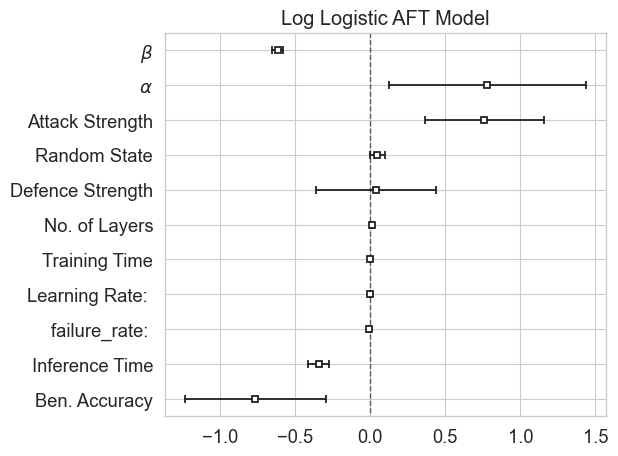

<lifelines.LogLogisticAFTFitter: fitted with 1917 total observations, 0 right-censored observations>
             duration col = 'adv_fit_time'
                event col = 'adv_failure_rate'
   number of observations = 1917
number of events observed = 1917
           log-likelihood = -6048.10
         time fit was run = 2023-09-22 12:02:25 UTC

---
                                                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                                 
alpha_ accuracy                                           -0.76       0.47       0.24            -1.23            -0.29                 0.29                 0.74
       atk_value                                           0.76       2.14       0.20             0.37             1.16                 1.44                 3.17
       data.sample.random_state                            0.05       1.05       0.03            -0.00             0.10                 1.00                 1.11
       def_value                                           0.04       1.04       0.20            -0.36             0.44                 0.70                 1.56
       failure_rate                                       -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
       model.art.pipeline.initialize.kwargs.optimizer.lr  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       model_layers                                        0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
       predict_time                                       -0.34       0.71       0.04            -0.41            -0.27                 0.66                 0.76
       train_time                                          0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
       Intercept                                           0.78       2.18       0.34             0.12             1.44                 1.13                 4.21
beta_  Intercept                                          -0.62       0.54       0.02            -0.65            -0.58                 0.52                 0.56

                                                           cmp to      z      p   -log2(p)
param  covariate                                                                          
alpha_ accuracy                                              0.00  -3.19 <0.005       9.45
       atk_value                                             0.00   3.78 <0.005      12.63
       data.sample.random_state                              0.00   1.83   0.07       3.88
       def_value                                             0.00   0.20   0.84       0.25
       failure_rate                                          0.00  -3.54 <0.005      11.29
       model.art.pipeline.initialize.kwargs.optimizer.lr     0.00  -1.33   0.19       2.43
       model_layers                                          0.00   5.16 <0.005      21.98
       predict_time                                          0.00  -9.65 <0.005      70.82
       train_time                                            0.00   5.04 <0.005      21.02
       Intercept                                             0.00   2.33   0.02       5.64
beta_  Intercept                                             0.00 -33.40 <0.005     810.23
---
Concordance = 0.59
AIC = 12118.20
log-likelihood ratio test = 147.29 on 9 df
-log2(p) of ll-ratio test = 88.01

In [ ]:
log_logistic_dict = {
    "Intercept: beta_": "$\\beta$",
    "Intercept: alpha_": "$\\alpha$",
    "data.sample.random_state: alpha_": "Random State",
    "def_value: alpha_": "Defence Strength",
    "atk_value: alpha_": "Attack Strength",
    "train_time: alpha_": "Training Time",
    "predict_time: alpha_": "Inference Time",
    "adv_accuracy: alpha_": "Adv. Accuracy",
    "accuracy: alpha_": "Ben. Accuracy",
    "adv_fit_time: alpha_": "Adv. Fit Time",
    "model_layers: alpha_": "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr" : "Learning Rate",
    "adv_failure_rate: alpha_": "Adv. Failure Rate",
    "alpha_" : "",

}

log_logistic_graph, llt = plot_aft(
    X_train,
    "log_logistic_aft.pdf",
    target,
    "adv_fit_time",
    "Log Logistic AFT Model",
    "log_logistic",
    replacement_dict=log_logistic_dict,
)
llt.print_summary()
llt_scores = score_model(llt, X_train, X_test)


In [ ]:
aft_dict = {
    "Weibull": wft,
    "LogNormal": lnt,
    "LogLogistic": llt,
    "Cox": cft,
}
aft_data = pd.DataFrame()
aft_data.index.name = "Model"
aft_data.index = aft_dict.keys()
aft_data["AIC"] = [x.AIC_ if not isinstance(x, CoxPHFitter) else np.nan for x in aft_dict.values() ]
# aft_data["LogLikelihood"] = [x.log_likelihood_ for x in aft_dict.values()]
aft_data["Concordance Score"] = [x.concordance_index_ for x in aft_dict.values()]
aft_data["BIC"] = [x.AIC_ if not isinstance(x, CoxPHFitter) else np.nan for x in aft_dict.values()]
aft_data['Train Log Likelihood'] = [x['train_score'] for x in [wft_scores, lnt_scores, llt_scores, cox_scores]]
aft_data['Test Log Likelihood'] = [x['test_score'] for x in [wft_scores, lnt_scores, llt_scores, cox_scores]]
aft_data['Mean Survival Time'] = [x.mean_survival_time_  if hasattr(x, "mean_survival_time_") else np.nan for x in aft_dict.values()]
aft_data['Median Survival Time'] = [x.median_survival_time_ if hasattr(x, "median_survival_time_") else np.nan  for x in aft_dict.values()]
aft_data['True Median Survival Time'] = np.median(y_train)
aft_data['True Mean Survival Time'] = np.mean(y_train)
aft_data[r'Error (seconds)'] = (aft_data['Median Survival Time'] - aft_data['True Median Survival Time'])
aft_data[r'% Error from True Mean'] = (aft_data['Mean Survival Time'] - aft_data['True Mean Survival Time'] ) /aft_data['True Mean Survival Time'] * 100
del aft_data['True Median Survival Time']
del aft_data['True Mean Survival Time']
aft_data = aft_data.round(2)
aft_data.to_csv(FOLDER / "aft_comparison.csv")
logger.info(f"Saved AFT comparison to {FOLDER / 'aft_comparison.csv'}")
aft_data



,AIC,Concordance Score,BIC,Train Log Likelihood,Test Log Likelihood,Mean Survival Time,Median Survival Time,Error (seconds),% Error from True Mean
Weibull,12187.71,0.59,12187.71,-3.17,-5.53,92.66,6.24,-62.72,-83.40
LogNormal,11942.60,0.59,11942.60,-3.11,-3.16,344.56,3.37,-65.58,-38.27
LogLogistic,12118.20,0.59,12118.20,-3.15,-3.20,NaN,3.14,-65.81,NaN
Cox,NaN,0.59,NaN,-6.51,-5.64,NaN,NaN,NaN,NaN
